In [ ]:
!pip install ultralytics roboflow supervision==0.19.0 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.4/750.4 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.1/74.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.1/97.1 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import supervision as sv
import os
import cv2
from ultralytics import YOLO
from PIL import Image

In [ ]:
%cd /content/drive/MyDrive
HOME = os.getcwd()

/content/drive/MyDrive


In [ ]:
MODEL = f"{HOME}/runs/detect/train/weights/best.pt"
model = YOLO(MODEL)
model.fuse()

Model summary (fused): 168 layers, 11126745 parameters, 0 gradients, 28.4 GFLOPs


In [ ]:
SOURCE_VIDEO_PATH = f"{HOME}/videos/yarik.mp4"
TARGET_VIDEO_PATH = f"{HOME}/videos/yarik_predict_poligon1.mp4"

In [ ]:
def detect(frame: np.ndarray) -> sv.Detections:
    result = model.predict(frame, imgsz=1280, conf=0.5, verbose=False)[0]
    return sv.Detections.from_ultralytics(result)

In [ ]:
from dataclasses import replace
from typing import Iterable, Optional, Tuple

import cv2
import numpy as np
import numpy.typing as npt

from supervision import Detections
from supervision.detection.utils import clip_boxes, polygon_to_mask
from supervision.draw.color import Color
from supervision.draw.utils import draw_polygon, draw_text
from supervision.geometry.core import Position
from supervision.geometry.utils import get_polygon_center
from supervision.utils.internal import deprecated_parameter

In [ ]:
class PolygonZone:
    """
    A class for defining a polygon-shaped zone within a frame for detecting objects.

    Attributes:
        polygon (np.ndarray): A polygon represented by a numpy array of shape
            `(N, 2)`, containing the `x`, `y` coordinates of the points.
        frame_resolution_wh (Tuple[int, int]): The frame resolution (width, height)
        triggering_anchors (Iterable[sv.Position]): A list of positions specifying
            which anchors of the detections bounding box to consider when deciding on
            whether the detection fits within the PolygonZone
            (default: (sv.Position.BOTTOM_CENTER,)).
        current_count (int): The current count of detected objects within the zone
        mask (np.ndarray): The 2D bool mask for the polygon zone
    """

    @deprecated_parameter(
        old_parameter="triggering_position",
        new_parameter="triggering_anchors",
        map_function=lambda x: [x],
        warning_message="`{old_parameter}` in `{function_name}` is deprecated and will "
        "be remove in `supervision-0.23.0`. Use '{new_parameter}' "
        "instead.",
    )
    def __init__(
        self,
        polygon: npt.NDArray[np.int64],
        frame_resolution_wh: Tuple[int, int],
        triggering_anchors: Iterable[Position] = (Position.BOTTOM_CENTER,),
        # triggering_anchors: Iterable[Position] = (
        #     Position.CENTER,
        #     Position.CENTER_LEFT,
        #     Position.CENTER_RIGHT,
        #     Position.TOP_CENTER,
        #     Position.TOP_LEFT,
        #     Position.TOP_RIGHT,
        #     Position.BOTTOM_LEFT,
        #     Position.BOTTOM_CENTER,
        #     Position.BOTTOM_RIGHT,
        #     # Position.CENTER_OF_MASS,
        # )
    ):
        self.polygon = polygon.astype(int)
        self.frame_resolution_wh = frame_resolution_wh
        self.triggering_anchors = triggering_anchors

        self.current_count = 0

        width, height = frame_resolution_wh
        self.mask = polygon_to_mask(
            polygon=polygon, resolution_wh=(width + 1, height + 1)
        )

    def trigger(self, detections: Detections, class_names) -> npt.NDArray[np.bool_]:
        """
        Determines if the detections are within the polygon zone.

        Parameters:
            detections (Detections): The detections
                to be checked against the polygon zone

        Returns:
            np.ndarray: A boolean numpy array indicating
                if each detection is within the polygon zone
        """

        list_xyxy = []
        list_conf = []
        list_class_id = []
        list_class_name = []

        for obj in iter(detections):
            if obj[5]['class_name'] in class_names:
                list_xyxy.append(obj[0])
                list_conf.append(obj[2])
                list_class_id.append(obj[3])
                list_class_name.append(obj[5]['class_name'])

        if len(list_xyxy) == 0:
            return np.array([False])

        arr_xyxy = np.array(list_xyxy)
        arr_conf = np.array(list_conf)
        arr_class_id = np.array(list_class_id)
        arr_class_name = np.array(list_class_name)
        dict_class_names = {
            'class_name': arr_class_name
        }

        detections = Detections(
            xyxy = arr_xyxy,
            mask = None,
            confidence = arr_conf,
            class_id = arr_class_id,
            tracker_id = None,
            data = dict_class_names
            # xyxy=results.boxes.xyxy.cpu().numpy(),
            # confidence=results.boxes.conf.cpu().numpy(),
            # class_id=results.boxes.cls.cpu().numpy().astype(int)
        )

        if len(detections) == 0:
            return np.array([False])

        # flag = 0
        # for i in range(len(detections)):
        #     if detections[i]['class_name'][0] == 'ball':
        #         detections = detections[i]
        #         flag = 1
        #         break

        # if flag == 0:
        #     return np.array([False])


        clipped_xyxy = clip_boxes(
            xyxy=detections.xyxy, resolution_wh=self.frame_resolution_wh
        )
        clipped_detections = replace(detections, xyxy=clipped_xyxy)


        all_clipped_anchors = np.array(
            [
                np.ceil(clipped_detections.get_anchors_coordinates(anchor)).astype(int)
                for anchor in self.triggering_anchors
            ]
        )

        is_in_zone: npt.NDArray[np.bool_] = (
            self.mask[all_clipped_anchors[:, :, 1], all_clipped_anchors[:, :, 0]]
            .transpose()
            .astype(bool)
        )

        is_in_zone: npt.NDArray[np.bool_] = np.all(is_in_zone, axis=1)
        self.current_count = int(np.sum(is_in_zone))
        return is_in_zone.astype(bool)


class PolygonZoneAnnotator:
    """
    A class for annotating a polygon-shaped zone within a
        frame with a count of detected objects.

    Attributes:
        zone (PolygonZone): The polygon zone to be annotated
        color (Color): The color to draw the polygon lines
        thickness (int): The thickness of the polygon lines, default is 2
        text_color (Color): The color of the text on the polygon, default is black
        text_scale (float): The scale of the text on the polygon, default is 0.5
        text_thickness (int): The thickness of the text on the polygon, default is 1
        text_padding (int): The padding around the text on the polygon, default is 10
        font (int): The font type for the text on the polygon,
            default is cv2.FONT_HERSHEY_SIMPLEX
        center (Tuple[int, int]): The center of the polygon for text placement
        display_in_zone_count (bool): Show the label of the zone or not. Default is True
    """

    def __init__(
        self,
        zone: PolygonZone,
        color: Color,
        thickness: int = 2,
        text_color: Color = Color.BLACK,
        text_scale: float = 0.5,
        text_thickness: int = 1,
        text_padding: int = 10,
        display_in_zone_count: bool = True,
    ):
        self.zone = zone
        self.color = color
        self.thickness = thickness
        self.text_color = text_color
        self.text_scale = text_scale
        self.text_thickness = text_thickness
        self.text_padding = text_padding
        self.font = cv2.FONT_HERSHEY_SIMPLEX
        self.center = get_polygon_center(polygon=zone.polygon)
        self.display_in_zone_count = display_in_zone_count

    def annotate(self, scene: np.ndarray, label: Optional[str] = None) -> np.ndarray:
        """
        Annotates the polygon zone within a frame with a count of detected objects.

        Parameters:
            scene (np.ndarray): The image on which the polygon zone will be annotated
            label (Optional[str]): An optional label for the count of detected objects
                within the polygon zone (default: None)

        Returns:
            np.ndarray: The image with the polygon zone and count of detected objects
        """
        annotated_frame = draw_polygon(
            scene=scene,
            polygon=self.zone.polygon,
            color=self.color,
            thickness=self.thickness,
        )

        if self.display_in_zone_count:
            annotated_frame = draw_text(
                scene=annotated_frame,
                text=str(self.zone.current_count) if label is None else label,
                text_anchor=self.center,
                background_color=self.color,
                text_color=self.text_color,
                text_scale=self.text_scale,
                text_thickness=self.text_thickness,
                text_padding=self.text_padding,
                text_font=self.font,
            )

        return annotated_frame

In [ ]:
def setup_zone_above(detections, frame_wh):
    zones = []
    count_zone = 0
    for i in range(len(detections)):
        obj = detections[i]


        # choosing only baskets with confidence score >= 0.5
        if (obj.class_id[0] == 1) & (obj.confidence[0] >= 0.8):
            count_zone += 1

            obj_xyxy = obj.xyxy[0]

            # get coordinates of 4 points of bounding box
            obj_p1 = np.array([obj_xyxy[0], obj_xyxy[1]])
            obj_p2 = np.array([obj_xyxy[0], obj_xyxy[3]])
            obj_p3 = np.array([obj_xyxy[2], obj_xyxy[3]])
            obj_p4 = np.array([obj_xyxy[2], obj_xyxy[1]])

            # get height and width of bounding box
            obj_height = obj_xyxy[3] - obj_xyxy[1]
            obj_width = obj_xyxy[2] - obj_xyxy[0]

            # polygon construction strategy
            # 1) polygon width will be width of "basket" bounding box increased on 10% (5% from left and right sides)
            # 2) polygon height will be height of "basket" bounding box
            # 3) obj_p1 and obj_p4 will become the zone_p2 and zone_p3 respectively
            # 4) polygon will be exactly above the basket bounding box

            zone_p1 = [obj_p1[0] - 0.05 * obj_width, obj_p1[1] - obj_height]
            zone_p2 = [obj_p1[0] - 0.05 * obj_width, obj_p1[1]]
            zone_p3 = [obj_p4[0] + 0.05 * obj_width, obj_p4[1]]
            zone_p4 = [obj_p4[0] + 0.05 * obj_width, obj_p4[1] - obj_height]

            # round coordinates of each point of zone
            zone_p1 = list(map(round, zone_p1))
            zone_p2 = list(map(round, zone_p2))
            zone_p3 = list(map(round, zone_p3))
            zone_p4 = list(map(round, zone_p4))

            zone_coordinates = np.array([zone_p1, zone_p2, zone_p3, zone_p4])
            zone_name = f"Zone {count_zone}"

            zone = {
                'name': zone_name,
                'polygon': zone_coordinates,
                'count': 0
            }

            zone['PolygonZone'] = PolygonZone(
                polygon=zone['polygon'],
                frame_resolution_wh=frame_wh
            )

            zone['PolygonZoneAnnotator'] = PolygonZoneAnnotator(
                zone=zone['PolygonZone'],
                color=sv.Color.WHITE,
                thickness=2,
                text_thickness=1,
                text_scale=0.3,
                text_padding=3
            )

            zones.append(zone)
    return zones

In [ ]:
def setup_zone_below(detections, frame_wh):
    zones = []
    count_zone = 0
    for i in range(len(detections)):
        obj = detections[i]


        # choosing only baskets with confidence score >= 0.8
        if (obj.class_id[0] == 1) & (obj.confidence[0] >= 0.8):
            count_zone += 1

            obj_xyxy = obj.xyxy[0]

            # get coordinates of 4 points of bounding box
            obj_p1 = np.array([obj_xyxy[0], obj_xyxy[1]])
            obj_p2 = np.array([obj_xyxy[0], obj_xyxy[3]])
            obj_p3 = np.array([obj_xyxy[2], obj_xyxy[3]])
            obj_p4 = np.array([obj_xyxy[2], obj_xyxy[1]])

            # get height and width of bounding box
            obj_height = obj_xyxy[3] - obj_xyxy[1]
            obj_width = obj_xyxy[2] - obj_xyxy[0]

            # polygon construction strategy
            # 1) polygon width will be width of "basket" bounding box increased on 10% (5% from left and right sides)
            # 2) polygon height will be height of "basket" bounding box
            # 3) polygon will be lower the basket bounding box on 0.5 height of it

            zone_p1 = [obj_p1[0] + 0.2 * obj_width, obj_p1[1] + 0.5 * obj_height]
            zone_p2 = [obj_p1[0] + 0.2 * obj_width, obj_p1[1] + 1.5 * obj_height]
            zone_p3 = [obj_p4[0] - 0.2 * obj_width, obj_p4[1] + 1.5 * obj_height]
            zone_p4 = [obj_p4[0] - 0.2 * obj_width, obj_p4[1] + 0.5 * obj_height]

            # round coordinates of each point of zone
            zone_p1 = list(map(round, zone_p1))
            zone_p2 = list(map(round, zone_p2))
            zone_p3 = list(map(round, zone_p3))
            zone_p4 = list(map(round, zone_p4))

            zone_coordinates = np.array([zone_p1, zone_p2, zone_p3, zone_p4])
            zone_name = f"Zone {count_zone}"

            zone = {
                'name': zone_name,
                'polygon': zone_coordinates,
                'count': 0
            }

            zone['PolygonZone'] = PolygonZone(
                polygon=zone['polygon'],
                frame_resolution_wh=frame_wh
            )

            zone['PolygonZoneAnnotator'] = PolygonZoneAnnotator(
                zone=zone['PolygonZone'],
                color=sv.Color.WHITE,
                thickness=2,
                text_thickness=1,
                text_scale=0.3,
                text_padding=3
            )

            zones.append(zone)
    return zones

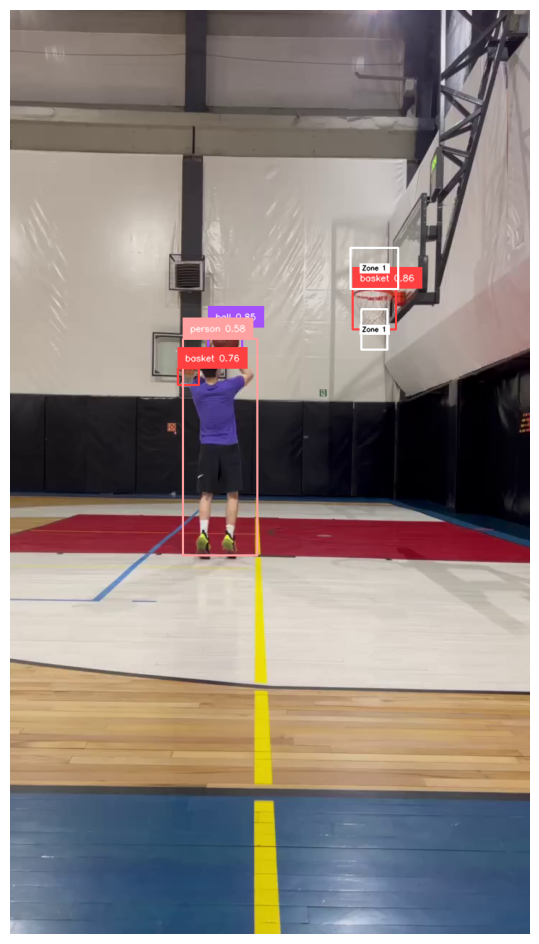

In [ ]:
frames_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)

frame = next(frames_generator) # get the 1st frame

detections = detect(frame)

# results = model(frame, verbose=False)[0]
# detections = sv.Detections.from_ultralytics(results)

video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)

zones_above = setup_zone_above(detections, video_info.resolution_wh)
zones_below = setup_zone_below(detections, video_info.resolution_wh)

# labels for bounding boxes
# labels = [
#     f"{results.names[class_id]} {confidence:0.2f}"
#     for class_id, confidence
#     in zip(detections.class_id, detections.confidence)
# ]
labels = [
    f"{model.model.names[class_id]} {confidence:0.2f}"
    for confidence, class_id
    in zip(detections.confidence, detections.class_id)
]

# draw bounding boxes
bounding_box_annotator = sv.BoundingBoxAnnotator(thickness=2)
label_annotator = sv.LabelAnnotator(text_thickness=1, text_scale=0.4)
annotated_frame = frame.copy()
annotated_frame = bounding_box_annotator.annotate(annotated_frame, detections)
annotated_frame = label_annotator.annotate(annotated_frame, detections, labels)

# draw zones
for zone in zones_above:
    annotated_frame = zone['PolygonZoneAnnotator'].annotate(
        scene=annotated_frame,
        label=f"{zone['name']}"
    )

for zone in zones_below:
    annotated_frame = zone['PolygonZoneAnnotator'].annotate(
        scene=annotated_frame,
        label=f"{zone['name']}"
    )

sv.plot_image(annotated_frame)

In [ ]:
def callback(frame: np.ndarray, frame_wh, frame_num: int, zones_above, zones_below, flag_above_prev, flag_below_prev, above_detected, intersection, score) -> np.ndarray:

    # results = model(frame, verbose=False)[0]
    # detections = sv.Detections.from_ultralytics(results)
    detections = detect(frame)
    # zones = []
    if frame_num == 1:
        zones_above = setup_zone_above(detections, frame_wh)
        zones_below = setup_zone_below(detections, frame_wh)

    labels = [
        f"{model.model.names[class_id]} {confidence:0.2f}"
        for confidence, class_id
        in zip(detections.confidence, detections.class_id)
    ]

    annotated_frame = frame.copy()

    annotated_frame = bounding_box_annotator.annotate(
        scene=annotated_frame,
        detections=detections)
    annotated_frame = label_annotator.annotate(
        scene=annotated_frame,
        detections=detections,
        labels=labels)

    # get person and ball bounding boxes coordinates
    person_x1 = person_y1 = person_x2 = person_y2 = 0
    ball_x1 = ball_y1 = ball_x2 = ball_y2 = 0
    for obj in iter(detections):

        # choose the person bounding box coordinates
        if obj[5]['class_name'] == 'person':

            # obj[0]: bounding boxes coordinates in format `[x1, y1, x2, y2]
            person_x1, person_y1, person_x2, person_y2 = obj[0]

        # choose the ball bounding box coordinates
        if obj[5]['class_name'] == 'ball':

            # obj[0]: bounding boxes coordinates in format `[x1, y1, x2, y2]
            ball_x1, ball_y1, ball_x2, ball_y2 = obj[0]


    # check the bounding boxes for no intersection conditions
    if person_x2 < ball_x1 or ball_x2 < person_x1:  # One box is to the left of the other
        intersection = False
        text_anchor = sv.Point(x=500, y=50)
        annotated_frame = draw_text(scene=annotated_frame, text=f"NO INTERSECTION", text_anchor=text_anchor, text_scale=1, text_thickness=2, text_color=Color.GREEN)

    elif person_y1 > ball_y2 or ball_y1 > person_y2:  # One box is above the other
        intersection = False
        text_anchor = sv.Point(x=500, y=50)
        annotated_frame = draw_text(scene=annotated_frame, text=f"NO INTERSECTION", text_anchor=text_anchor, text_scale=1, text_thickness=2, text_color=Color.GREEN)

    else: # no intersection
        interection = True
        above_detected = False
        text_anchor = sv.Point(x=500, y=50)
        annotated_frame = draw_text(scene=annotated_frame, text=f"INTERSECTION", text_anchor=text_anchor, text_scale=1, text_thickness=2, text_color=Color.RED)

    if above_detected:
        text_anchor = sv.Point(x=500, y=100)
        annotated_frame = draw_text(scene=annotated_frame, text=f"above_detected: {above_detected}", text_anchor=text_anchor, text_scale=1, text_thickness=2, text_color=Color.GREEN)
    else:
        text_anchor = sv.Point(x=500, y=100)
        annotated_frame = draw_text(scene=annotated_frame, text=f"above_detected: {above_detected}", text_anchor=text_anchor, text_scale=1, text_thickness=2, text_color=Color.RED)

    for zone in zones_above:
        zone_presence = zone['PolygonZone'].trigger(detections, ['ball'])
        zone_present_idxs = [idx for idx, present in enumerate(zone_presence) if present]
        zone_present = detections[zone_present_idxs]

        zone_count = len(zone_present)

        count_prev = zone['count']

        flag = 0
        if zone_count > 0:
            flag = 1

        if (flag == 0) and (flag_above_prev == 1) and (intersection == False):
            zone['count'] += 1

        if zone['count'] > count_prev:
            above_detected = True


        annotated_frame = zone['PolygonZoneAnnotator'].annotate(
            scene=annotated_frame,
            label=f"{zone['name']}: {zone['count']}"
        )
        flag_above_prev = flag

    for zone in zones_below:
        zone_presence = zone['PolygonZone'].trigger(detections, ['ball'])
        zone_present_idxs = [idx for idx, present in enumerate(zone_presence) if present]
        zone_present = detections[zone_present_idxs]

        zone_count = len(zone_present)

        count_prev = zone['count']

        flag = 0
        if zone_count > 0:
            flag = 1

        if (flag == 0) and (flag_below_prev == 1) and (intersection == False):
            zone['count'] += 1

        if (zone['count'] > count_prev) and (above_detected == True):
            score += 1
            above_detected = False


        annotated_frame = zone['PolygonZoneAnnotator'].annotate(
            scene=annotated_frame,
            label=f"{zone['name']}: {zone['count']}"
        )
        flag_below_prev = flag


    text_anchor = sv.Point(x=130, y=50)
    annotated_frame = draw_text(scene=annotated_frame, text=f"Counter: {score}", text_anchor=text_anchor, text_scale=1.5, text_thickness=2)


    return annotated_frame, zones_above, zones_below, flag_above_prev, flag_below_prev, above_detected, intersection, score

In [ ]:
SOURCE_VIDEO_PATH = f"{HOME}/videos/yarik.mp4"
TARGET_VIDEO_PATH = f"{HOME}/videos/yarik_predict.mp4"

frames_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)

zones_above = []
zones_below = []
flag_above_prev = 0
flag_below_prev = 0
above_detected = False
intersection = False
score = 0

with sv.VideoSink(target_path=TARGET_VIDEO_PATH, video_info=video_info) as sink:
    for i, frame in enumerate(frames_generator):

        # Infer
        annotated_frame, zones_above, zones_below, flag_above_prev, flag_below_prev, above_detected, intersection, score = \
        callback(frame, video_info.resolution_wh, i, zones_above, zones_below, flag_above_prev, flag_below_prev, above_detected, intersection, score)
        # print(f"Processing frame {i}, zones_above: {zones_above['count']}, zones_below: {zones_below['count']}")
        print(f"Processing frame {i}, Score {score}")
        sink.write_frame(frame=annotated_frame)

Processing frame 0, Score 0
Processing frame 1, Score 0
Processing frame 2, Score 0
Processing frame 3, Score 0
Processing frame 4, Score 0
Processing frame 5, Score 0
Processing frame 6, Score 0
Processing frame 7, Score 0
Processing frame 8, Score 0
Processing frame 9, Score 0
Processing frame 10, Score 0
Processing frame 11, Score 0
Processing frame 12, Score 0
Processing frame 13, Score 0
Processing frame 14, Score 0
Processing frame 15, Score 0
Processing frame 16, Score 0
Processing frame 17, Score 0
Processing frame 18, Score 0
Processing frame 19, Score 0
Processing frame 20, Score 0
Processing frame 21, Score 0
Processing frame 22, Score 0
Processing frame 23, Score 0
Processing frame 24, Score 0
Processing frame 25, Score 0
Processing frame 26, Score 0
Processing frame 27, Score 0
Processing frame 28, Score 0
Processing frame 29, Score 0
Processing frame 30, Score 0
Processing frame 31, Score 0
Processing frame 32, Score 1
Processing frame 33, Score 1
Processing frame 34, Sco